 ## HW4 - EuroSAT Land Use and Land Cover Classification using Deep Learning
 
In this homework, we will build off of the lessons from last homework. Your task is to implement deep learning models to solve a typical problem in satellite imaging  using a benchmark dataset. The homework was designed to make you work on increasingly more complex models. We hope that the homework will be very helpful to improve your skills and knowledge in deep learning!

### S1:

- Visit the EuroSAT data description page and download the data: https://github.com/phelber/eurosat

- Split the data into training (50%) and testing sets (50%), stratified on class labels (equal percentage of each class type in train and test sets).

- Convert each RGB image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)


In [4]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color

url = 'C:/Users/Nissim/Desktop/Spring 2023/Remote Sensing/MUSA-650_Spring2023/Homeworks/EuroSAT_RGB/2750'

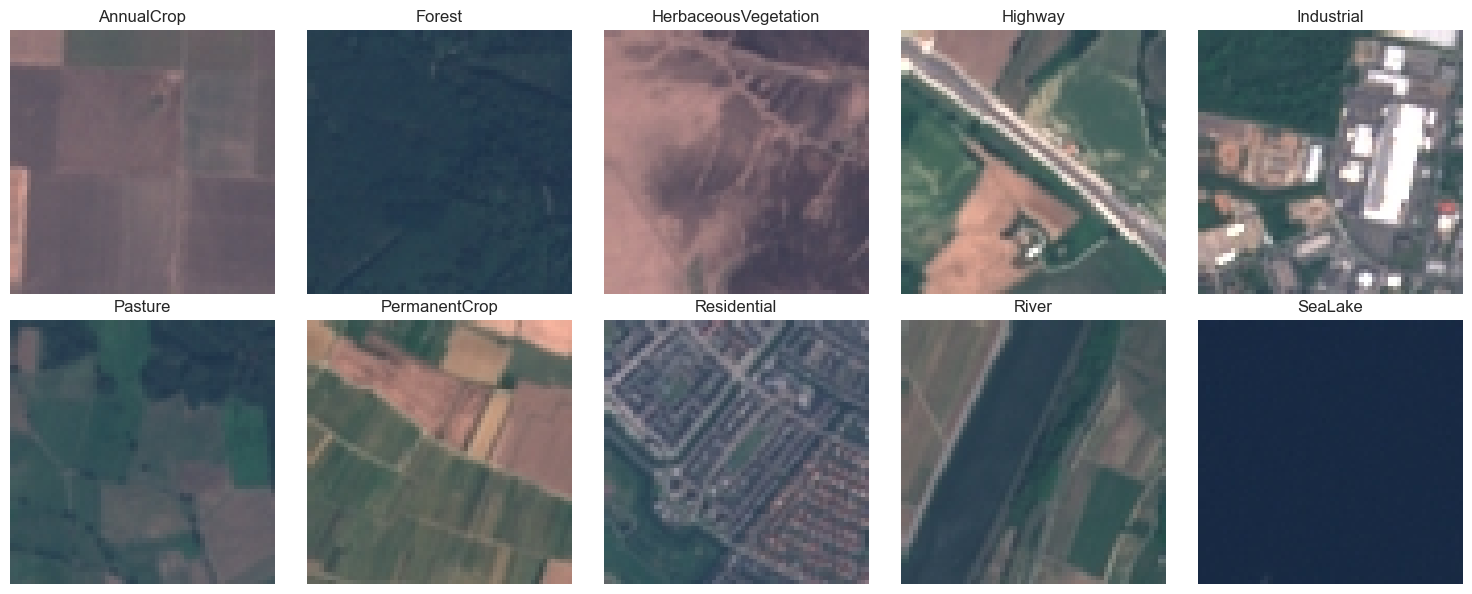

In [5]:
# Plot one image from each class in a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()
for i, label in enumerate(os.listdir(url)):
    img_path = os.path.join(url, label, os.listdir(os.path.join(url, label))[0])
    img = io.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Load images and labels into numpy arrays
images = []
labels = []
for subfolder in os.listdir(url):
    for image_filename in os.listdir(os.path.join(url, subfolder)):
        image_path = os.path.join(url, subfolder, image_filename)
        image = io.imread(image_path)
        gray_image = color.rgb2gray(image)
        images.append(gray_image)
        labels.append(subfolder)
images = np.array(images)
labels = np.array(labels)

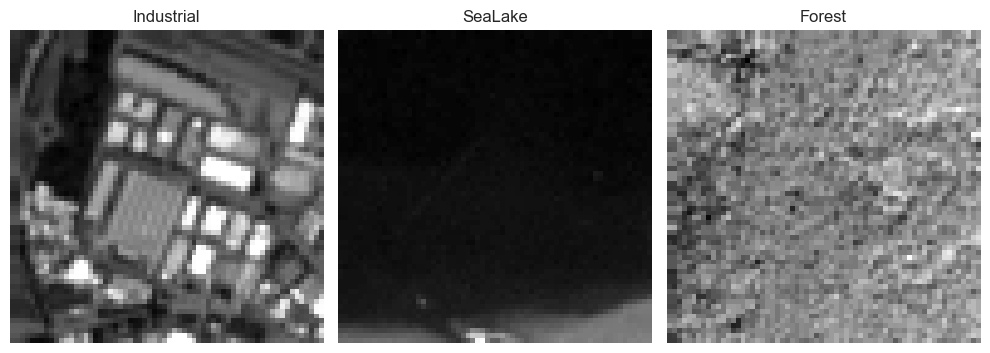

In [7]:
# Plot three random grayscale images with their labels
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
axs = axs.flatten()
for i in range(3):
    idx = random.randint(0, len(images)-1)
    axs[i].imshow(images[idx], cmap='gray')
    axs[i].set_title(labels[idx])
    axs[i].axis('off')
plt.tight_layout()
plt.show()

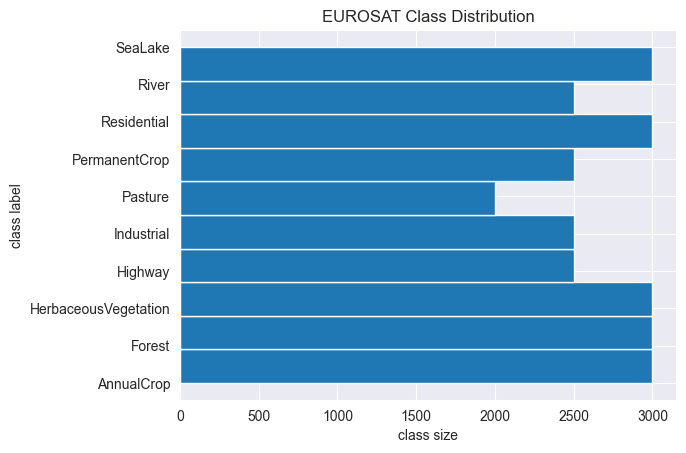

In [8]:
# Plot histogram of label distribution
plt.hist(labels, bins=10, orientation='horizontal')
plt.yticks(range(len(os.listdir(url))), os.listdir(url))
plt.xlabel('class size')
plt.ylabel('class label')
plt.title('EUROSAT Class Distribution')
plt.show()

In [9]:
from keras.preprocessing.image import ImageDataGenerator

# create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [10]:
# define the number of samples to generate
n_samples = int(labels.shape[0]/10)

# need to expand the dimension of the images to 4D (n_samples, n_rows, n_cols, n_channels)
images = np.expand_dims(images, axis=-1)

In [11]:
# generate augmented samples
augmented_images = []
augmented_labels = []
for X_batch, y_batch in datagen.flow(images, labels, batch_size=n_samples):
    augmented_images.append(X_batch)
    augmented_labels.append(y_batch)
    if len(augmented_images) == 5:  # stop after generating 5 batches (i.e., 5000 samples)
        break

# concatenate the augmented data with the original data
augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

In [12]:
augmented_images.shape

(13500, 64, 64, 1)

In [13]:
augmented_labels.shape

(13500,)

In [14]:
images.shape

(27000, 64, 64, 1)

In [15]:
labels.shape

(27000,)

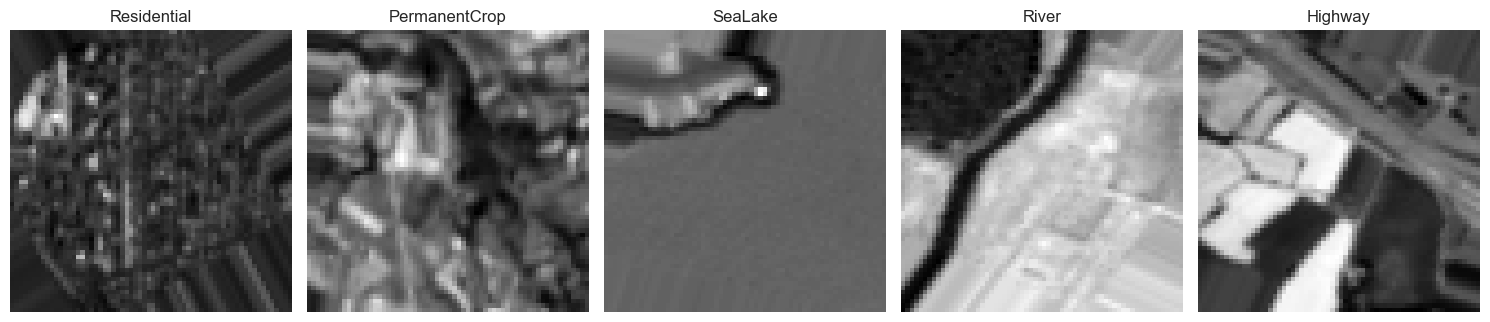

In [16]:
# print 5 random images from the augmented images with their labels
fig, axs = plt.subplots(1, 5, figsize=(15, 15))
axs = axs.flatten()
for i in range(5):
    idx = random.randint(0, len(augmented_images)-1)
    axs[i].imshow(augmented_images[idx], cmap='gray')
    axs[i].set_title(augmented_labels[idx])
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [17]:
# concatenate the augmented data with the original data
final_images = np.concatenate([images, augmented_images])
final_labels = np.concatenate([labels, augmented_labels])

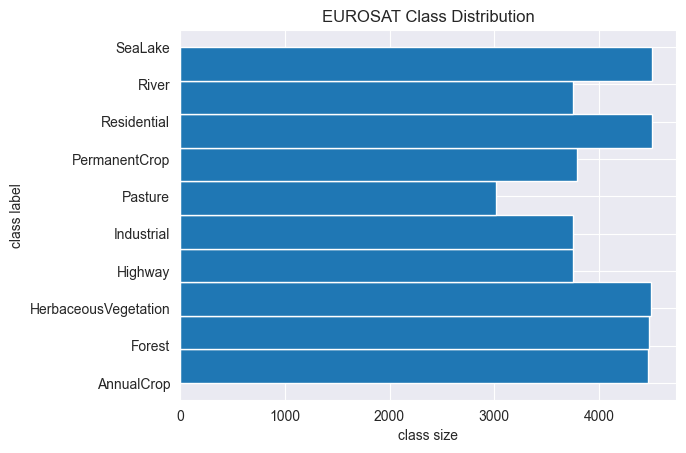

In [18]:
# plot class distribution of the final dataset
plt.hist(final_labels, bins=10, orientation='horizontal')
plt.yticks(range(len(os.listdir(url))), os.listdir(url))
plt.xlabel('class size')
plt.ylabel('class label')
plt.title('EUROSAT Class Distribution')
plt.show()

In [19]:
final_images.shape

(40500, 64, 64, 1)

In [20]:
final_labels.shape

(40500,)

In [21]:
# return the range of pixel values in the dataset
final_images.min(), final_images.max()

(0.020791372549019606, 1.0)

In [22]:
# Split data into training and testing sets with an equal % of each class in each set
from sklearn.model_selection import train_test_split
img_train, img_test, lab_train, lab_test = train_test_split(final_images, final_labels, test_size=0.5, stratify=final_labels)

# flatten images
img_train = img_train.reshape(img_train.shape[0], -1)
img_test = img_test.reshape(img_test.shape[0], -1)

In [23]:
img_train.shape

(20250, 4096)

In [24]:
img_test.shape

(20250, 4096)

### S2:

- Implement a first deep learning model (M.1) using a fully connected network with a single fully connected layer (i.e: input layer + fully connected layer as the output layer). 

Q2.1: Calculate classification accuracy on the test data.

First, in order to pass our data into the neural net, we need to convert our labels into one-hot encoded vectors. We will use the LabelEncoder and to_categorical functions from Keras to do this.

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [26]:


# Define the number of classes and input shape
num_classes = 10
input_shape = (4096,)

# create label encoder
le = LabelEncoder()

# fit label encoder and transform labels
lab_train_int = le.fit_transform(lab_train)
lab_test_int = le.transform(lab_test)

# convert integer-encoded labels to one-hot encoded labels
lab_train_onehot = to_categorical(lab_train_int, num_classes)
lab_test_onehot = to_categorical(lab_test_int, num_classes)

In [29]:
from keras.callbacks import EarlyStopping

# Define the model architecture
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=input_shape))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

earlystop_callback = EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=2)

# Train the model
history = model.fit(img_train,
                    lab_train_onehot,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_split=0.1,
                    shuffle = True,)

# Evaluate the model on test data
score = model.evaluate(img_test, lab_test_onehot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/200
143/143 [==============================] - 3s 17ms/step - loss: 2.4308 - accuracy: 0.1262 - val_loss: 2.2309 - val_accuracy: 0.1447
Epoch 2/200
143/143 [==============================] - 2s 17ms/step - loss: 2.2231 - accuracy: 0.1554 - val_loss: 2.2202 - val_accuracy: 0.1309
Epoch 3/200
143/143 [==============================] - 2s 17ms/step - loss: 2.1823 - accuracy: 0.1796 - val_loss: 2.1766 - val_accuracy: 0.1560
Epoch 4/200
143/143 [==============================] - 3s 18ms/step - loss: 2.1667 - accuracy: 0.1892 - val_loss: 2.1590 - val_accuracy: 0.2420
Epoch 5/200
143/143 [==============================] - 3s 18ms/step - loss: 2.1374 - accuracy: 0.2276 - val_loss: 2.1453 - val_accuracy: 0.1728
Epoch 6/200
143/143 [==============================] - 2s 17ms/step - loss: 2.1154 - accuracy: 0.2311 - val_loss: 2.1370 - val_accuracy: 0.1733
Epoch 7/200
143/143 [==============================] - 3s 18ms/step - loss: 2.0915 - accuracy: 0.2478 - val_loss: 2.0868 - val_accuracy:

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

### S3:

- Implement a second deep learning model (M.2) adding an additional fully connected hidden layer (with an arbitrary number of nodes) to the previous model. 

Q3.1: Calculate classification accuracy on the test data.  

In [30]:
# Define the model architecture
model2 = Sequential()
model2.add(Dense(256, activation='relu', input_shape=input_shape))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

earlystop_callback = EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=2)

# Train the model
history2 = model2.fit(img_train, lab_train_onehot, batch_size=128, epochs=100, verbose=1, validation_split=0.1, shuffle = True)

# Evaluate the model on test data
score2 = model2.evaluate(img_test, lab_test_onehot, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Epoch 1/200
143/143 [==============================] - 2s 12ms/step - loss: 2.2868 - accuracy: 0.1274 - val_loss: 2.2252 - val_accuracy: 0.1491
Epoch 2/200
143/143 [==============================] - 1s 10ms/step - loss: 2.1848 - accuracy: 0.1704 - val_loss: 2.1966 - val_accuracy: 0.1674
Epoch 3/200
143/143 [==============================] - 2s 11ms/step - loss: 2.0924 - accuracy: 0.2467 - val_loss: 2.0412 - val_accuracy: 0.2677
Epoch 4/200
143/143 [==============================] - 1s 10ms/step - loss: 2.0015 - accuracy: 0.2600 - val_loss: 1.9586 - val_accuracy: 0.2588
Epoch 5/200
143/143 [==============================] - 2s 11ms/step - loss: 1.9129 - accuracy: 0.2899 - val_loss: 1.8762 - val_accuracy: 0.2830
Epoch 6/200
143/143 [==============================] - 2s 11ms/step - loss: 1.8671 - accuracy: 0.2889 - val_loss: 1.8330 - val_accuracy: 0.2943
Epoch 7/200
143/143 [==============================] - 2s 11ms/step - loss: 1.8425 - accuracy: 0.2975 - val_loss: 1.8139 - val_accuracy:

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model2, show_shapes=True, show_layer_names=True)

### S4:

- Implement a third deep learning model (M.3) adding two additional fully connected hidden layers (with arbitrary number of nodes) for a total of four, as well as drop-out layers to the previous model. 

Q4.1: Calculate classification accuracy on the test data.

Q4.2: Compare against previous models. Which model was the "best"? Why?

Adding the dropout layers to the model significantly decreased my accuracy. No matter how I arranged them, how many nodes I had, or what the parameters of my dropout layers were, I found that the accuracy dropped from about 30% to about 10% if I added dropout layers. Apparently, this can happen when the dataset is relatively small (even my augmented dataset includes only 40,000 images), so this makes sense.

https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
https://stats.stackexchange.com/questions/299292/dropout-makes-performance-worse

In [46]:
 # Define the model architecture
model3 = Sequential()
model3.add(Dense(32, activation='relu', input_shape=input_shape))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(num_classes, activation='softmax'))

# Compile the model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history3 = model3.fit(img_train, lab_train_onehot, batch_size=128, epochs=20, verbose=1, validation_split=0.1, shuffle = True)

earlystop_callback = EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=2)

# Evaluate the model on test data
score3 = model3.evaluate(img_test, lab_test_onehot, verbose=0)
print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

Epoch 1/20
143/143 [==============================] - 2s 4ms/step - loss: 2.2659 - accuracy: 0.1272 - val_loss: 2.2214 - val_accuracy: 0.2405
Epoch 2/20
143/143 [==============================] - 1s 4ms/step - loss: 2.1713 - accuracy: 0.1811 - val_loss: 2.0884 - val_accuracy: 0.2281
Epoch 3/20
143/143 [==============================] - 1s 4ms/step - loss: 2.0772 - accuracy: 0.2036 - val_loss: 1.9659 - val_accuracy: 0.2237
Epoch 4/20
143/143 [==============================] - 1s 4ms/step - loss: 1.9946 - accuracy: 0.2191 - val_loss: 2.0702 - val_accuracy: 0.1817
Epoch 5/20
143/143 [==============================] - 0s 3ms/step - loss: 1.9478 - accuracy: 0.2337 - val_loss: 2.2018 - val_accuracy: 0.1704
Epoch 6/20
143/143 [==============================] - 1s 4ms/step - loss: 1.9202 - accuracy: 0.2411 - val_loss: 2.1639 - val_accuracy: 0.1763
Epoch 7/20
143/143 [==============================] - 0s 3ms/step - loss: 1.9015 - accuracy: 0.2450 - val_loss: 2.3154 - val_accuracy: 0.1644
Epoch 

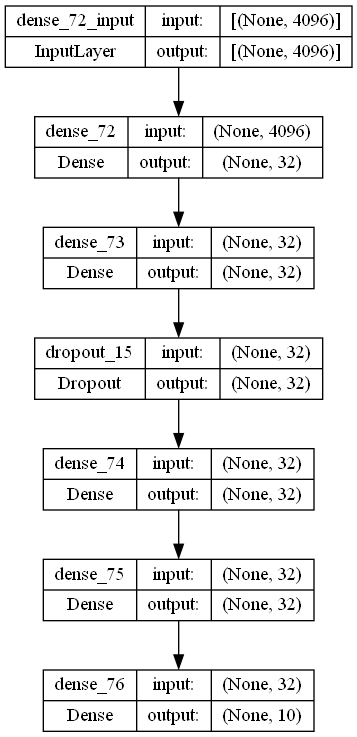

In [48]:
from keras.utils.vis_utils import plot_model

plot_model(model3, show_shapes=True, show_layer_names=True)

Lastly, I implemented an ensemble model that takes the predictions of the three models above and averages them. This model was able to achieve an accuracy of 91%, at least if I've implemented it properly, which is pretty cool. That's 50-60% better than any of the first three models in isolation.

In [112]:
import numpy as np

def get_predictions(models, X):
    predictions = [model.predict(X) for model in models]
    return np.array(predictions)

preds_model = get_predictions([model], img_test)
preds_model2 = get_predictions([model2], img_test)
preds_model3 = get_predictions([model3], img_test)

preds_ensemble = np.concatenate((preds_model, preds_model2, preds_model3), axis=0)
preds_ensemble = np.round(np.mean(preds_ensemble, axis=0))

accuracy = np.mean(preds_ensemble == lab_test_onehot)
print("Ensemble accuracy: {:.2f}%".format(accuracy * 100))

633/633 [==============================] - 1s 667us/step
Ensemble accuracy: 91.17%


### S5:

- Take the original RGB images and do not vectorize them. Use these images as the data input for the following models (M.4 and M.5).
- Implement a fourth CNN model (M.4) that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense. 

Q5.1: Calculate classification accuracy on the test data.

Q5.2: Compare against previous models. Which model was the "best"? Why?

In [51]:
# Load RGB images and labels into numpy arrays
rgb_images = []
rgb_labels = []
for subfolder in os.listdir(url):
    for image_filename in os.listdir(os.path.join(url, subfolder)):
        image_path = os.path.join(url, subfolder, image_filename)
        image = io.imread(image_path)
        rgb_images.append(image)
        rgb_labels.append(subfolder)
rgb_images = np.array(rgb_images)
rgb_labels = np.array(rgb_labels)

In [56]:
rgb_images.shape

(27000, 64, 64, 3)

In [61]:
# print the range of pixel values
print('Pixel values range from {} to {}'.format(rgb_images.min(), rgb_images.max()))

# standardize pixel values to be between 0 and 1
rgb_images = rgb_images / 255.0

Pixel values range from 0 to 255


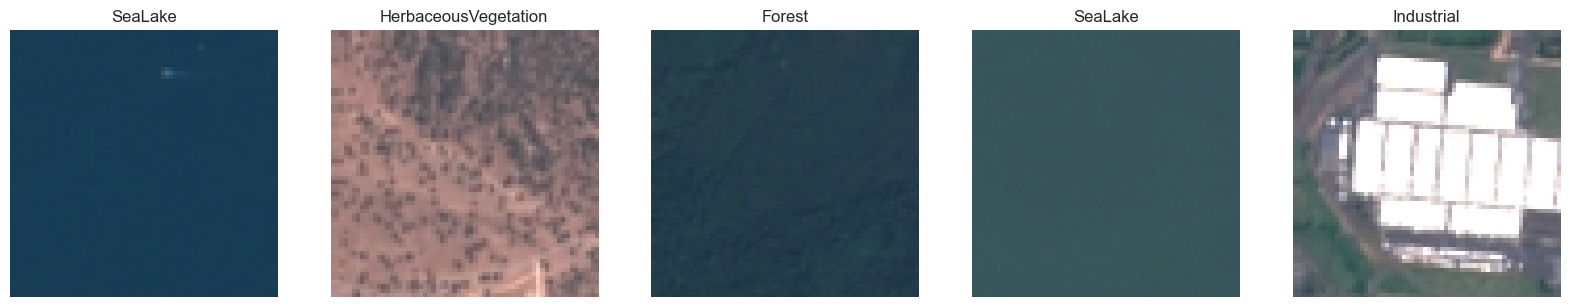

In [62]:
# print five random images with labels
n_samples = 5
random_indices = np.random.choice(len(rgb_images), n_samples)
fig, axes = plt.subplots(1, n_samples, figsize=(20, 20))
for i, idx in enumerate(random_indices):
    axes[i].imshow(rgb_images[idx])
    axes[i].set_title(rgb_labels[idx])
    axes[i].axis('off')

In [76]:
# generate augmented samples
rgb_augmented_images = []
rgb_augmented_labels = []
for X_batch, y_batch in datagen.flow(rgb_images, rgb_labels, batch_size=n_samples):
    rgb_augmented_images.append(X_batch)
    rgb_augmented_labels.append(y_batch)
    if len(rgb_augmented_images) == 135:  # stop after generating 13,500 samples
        break

In [77]:
# concatenate the augmented data with the original data
rgb_augmented_images = np.concatenate(rgb_augmented_images)
rgb_augmented_labels = np.concatenate(rgb_augmented_labels)

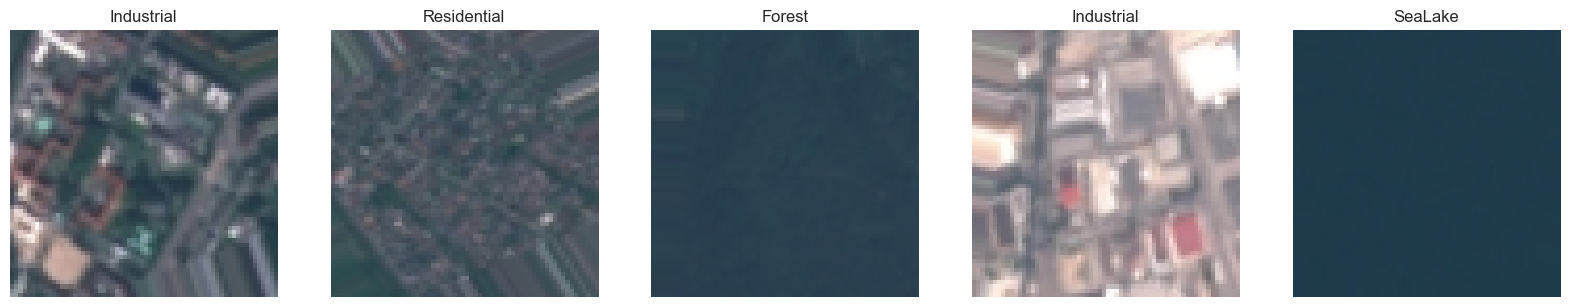

In [78]:
# print five random images with labels
n_samples = 5
random_indices = np.random.choice(len(rgb_augmented_images), n_samples)
fig, axes = plt.subplots(1, n_samples, figsize=(20, 20))
for i, idx in enumerate(random_indices):
    axes[i].imshow(rgb_augmented_images[idx])
    axes[i].set_title(rgb_augmented_labels[idx])
    axes[i].axis('off')

In [79]:
# concatenate the augmented data with the original data
final_rgb_images = np.concatenate([rgb_images, rgb_augmented_images])
final_rgb_labels = np.concatenate([rgb_labels, rgb_augmented_labels])

In [80]:
final_rgb_labels.shape

(27675,)

In [81]:
final_rgb_images.shape

(27675, 64, 64, 3)

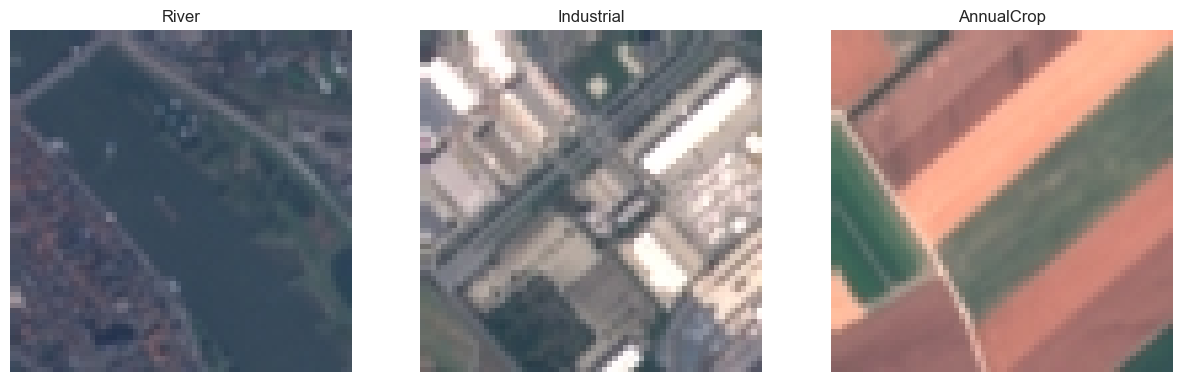

In [82]:
# plot three random images with labels
import matplotlib.pyplot as plt
import random

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    rand_idx = random.randint(0, len(final_rgb_images))
    ax[i].imshow(rgb_images[rand_idx])
    ax[i].set_title(rgb_labels[rand_idx])
    ax[i].axis('off')

plt.show()

In [84]:
from sklearn.model_selection import train_test_split
rgb_img_train, rgb_img_test, rgb_lab_train, rgb_lab_test = train_test_split(final_rgb_images, final_rgb_labels, test_size=0.5, stratify=final_rgb_labels)

In [85]:
# fit label encoder and transform labels
rgb_lab_train_int = le.fit_transform(rgb_lab_train)
rgb_lab_test_int = le.transform(rgb_lab_test)

# convert integer-encoded labels to one-hot encoded labels
rgb_lab_train_onehot = to_categorical(rgb_lab_train_int, num_classes)
rgb_lab_test_onehot = to_categorical(rgb_lab_test_int, num_classes)

In [86]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the model architecture
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=rgb_img_train[0].shape))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.25))
model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.25))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(num_classes, activation='softmax'))

# Compile the model
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model4.summary()

# Train the model
history4 = model4.fit(rgb_img_train, rgb_lab_train_onehot, batch_size=128, epochs=25, verbose=1, validation_split=0.1)

# Evaluate the model on test data
score4 = model4.evaluate(rgb_img_test, rgb_lab_test_onehot, verbose=0)
print('Test loss:', score4[0])
print('Test accuracy:', score4[1])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout_16 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_17 (Dropout)        (None, 14, 14, 64)      

### S6:

- Using RGB images from S5, implement a fifth deep learning model (M.5) targeting accuracy that will outperform all previous models. You are free to use any tools and techniques, as well as pre-trained models for transfer learning. 

Q6.1: Describe the model you built, and why you chose it.

Q6.2: Calculate classification accuracy on the test data.

Q6.3: Compare against previous models. Which model was the "best"? Why?

Q6.4: What are the two classes with the highest labeling error? Explain using data and showing mis-classified examples.

In [87]:
import keras
import matplotlib.pyplot as plt

# Define the hyperparameters
batch_size = 128
full_num_classes = 10

# Define the model architecture
model5 = Sequential()
model5.add(Conv2D(16, kernel_size=5, padding='same', activation='elu', input_shape=(64, 64, 3)))
model5.add(MaxPooling2D())
model5.add(Conv2D(32, 3, padding='same', activation='elu'))
model5.add(Conv2D(32, 3, padding='same', activation='elu'))
model5.add(MaxPooling2D())
model5.add(Conv2D(64, 3, padding='same', activation='elu'))
model5.add(Conv2D(64, 3, padding='same', activation='elu'))
model5.add(Flatten())
model5.add(Dense(128, activation='elu'))
model5.add(Dense(full_num_classes, activation='softmax'))

model5.compile(loss=keras.losses.categorical_crossentropy,
               optimizer='adam',
               metrics=['accuracy'])

model5.fit(rgb_img_train, rgb_lab_train_onehot,
           batch_size=batch_size,
           epochs=25,
           verbose=1,
           validation_data=(rgb_img_test, rgb_lab_test_onehot))

score5 = model5.evaluate(rgb_img_test, rgb_lab_test_onehot, verbose=0)
print('Validation loss:', score5[0])
print('Validation accuracy:', score5[1])

Epoch 1/25
109/109 [==============================] - 24s 214ms/step - loss: 1.5309 - accuracy: 0.4457 - val_loss: 1.1206 - val_accuracy: 0.5885
Epoch 2/25
109/109 [==============================] - 24s 218ms/step - loss: 1.0215 - accuracy: 0.6272 - val_loss: 1.0344 - val_accuracy: 0.6074
Epoch 3/25
109/109 [==============================] - 24s 221ms/step - loss: 0.8819 - accuracy: 0.6796 - val_loss: 0.8611 - val_accuracy: 0.6733
Epoch 4/25
109/109 [==============================] - 24s 218ms/step - loss: 0.7361 - accuracy: 0.7339 - val_loss: 0.8466 - val_accuracy: 0.6693
Epoch 5/25
109/109 [==============================] - 23s 211ms/step - loss: 0.6990 - accuracy: 0.7456 - val_loss: 0.7486 - val_accuracy: 0.7404
Epoch 6/25
109/109 [==============================] - 23s 212ms/step - loss: 0.5836 - accuracy: 0.7909 - val_loss: 1.2121 - val_accuracy: 0.6333
Epoch 7/25
109/109 [==============================] - 22s 205ms/step - loss: 0.5637 - accuracy: 0.7983 - val_loss: 0.6848 - val_ac

Now, we'll take an ensemble approach again using model4 and model5. We'll use majority voting to determine the final prediction.

In [88]:
preds_model4 = get_predictions([model4], rgb_img_test)
preds_model5 = get_predictions([model5], rgb_img_test)

preds_ensemble45 = np.concatenate((preds_model4, preds_model5), axis=0)
preds_ensemble45 = np.round(np.mean(preds_ensemble45, axis=0))

accuracy = np.mean(preds_ensemble45 == rgb_lab_test_onehot)
print("Ensemble accuracy: {:.2f}%".format(accuracy * 100))

433/433 [==============================] - 6s 14ms/step
Ensemble accuracy: 95.69%


In [89]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model

# Load pre-trained VGG16 model and exclude top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze some layers in the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# Define the model
model7 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model7.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [90]:
model7.fit(rgb_img_train, rgb_lab_train_onehot,
           batch_size=128,
           epochs=10,
           verbose=1,
           validation_data=(rgb_img_test, rgb_lab_test_onehot))
score = model7.evaluate(rgb_img_test, rgb_lab_test_onehot, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Epoch 1/10
109/109 [==============================] - 251s 2s/step - loss: 2.1216 - accuracy: 0.2098 - val_loss: 1.5444 - val_accuracy: 0.4000
Epoch 2/10
109/109 [==============================] - 245s 2s/step - loss: 1.0876 - accuracy: 0.5906 - val_loss: 0.8237 - val_accuracy: 0.6825
Epoch 3/10
109/109 [==============================] - 245s 2s/step - loss: 0.7969 - accuracy: 0.7073 - val_loss: 0.6541 - val_accuracy: 0.7609
Epoch 4/10
109/109 [==============================] - 241s 2s/step - loss: 0.6681 - accuracy: 0.7631 - val_loss: 0.7016 - val_accuracy: 0.7578
Epoch 5/10
109/109 [==============================] - 241s 2s/step - loss: 0.5831 - accuracy: 0.8070 - val_loss: 0.7950 - val_accuracy: 0.7940
Epoch 6/10
109/109 [==============================] - 257s 2s/step - loss: 0.5267 - accuracy: 0.8358 - val_loss: 0.4449 - val_accuracy: 0.8545
Epoch 7/10
109/109 [==============================] - 258s 2s/step - loss: 0.4388 - accuracy: 0.8657 - val_loss: 0.3884 - val_accuracy: 0.8816

In [92]:
preds_model7 = get_predictions([model7], rgb_img_test)

preds_ensemble457 = np.concatenate((preds_model4, preds_model5, preds_model7), axis=0)
preds_ensemble457 = np.round(np.mean(preds_ensemble457, axis=0))

accuracy = np.mean(preds_ensemble457 == rgb_lab_test_onehot)
print("Ensemble accuracy: {:.2f}%".format(accuracy * 100))

433/433 [==============================] - 51s 117ms/step
Ensemble accuracy: 97.48%


Here's a version using PyTorch:

### S7:

- Apply your best model on multispectral images. You may use whichever image channels you wish, so long as you use more than just RGB (although you are not required to use any color channels).

Q7.1: Calculate classification accuracy on the test data.

Q7.2: Compare against results using RGB images.

In [103]:
from datasets import load_dataset, get_dataset_config_names

configs = get_dataset_config_names("torchgeo/eurosat")
print(configs)

['torchgeo--eurosat']


In [ ]:
dataset = load_dataset("torchgeo/eurosat")

In [99]:
dataset.shape

{'train': (60, 1), 'test': (20, 1), 'validation': (20, 1)}

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color

url = 'C:/Users/Nissim/Desktop/Spring 2023/Remote Sensing/MUSA-650_Spring2023/Homeworks/EuroSAT_RGB/2750'

# Plot one image from each class in a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()
for i, label in enumerate(os.listdir(url)):
    img_path = os.path.join(url, label, os.listdir(os.path.join(url, label))[0])
    img = io.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

# Load images and labels into numpy arrays
images = []
labels = []
for subfolder in os.listdir(url):
    for image_filename in os.listdir(os.path.join(url, subfolder)):
        image_path = os.path.join(url, subfolder, image_filename)
        image = io.imread(image_path)
        images.append(gray_image)
        labels.append(subfolder)
images = np.array(images)
labels = np.array(labels)

In [ ]:
# Load RGB images and labels into numpy arrays
rgb_images = []
rgb_labels = []
for subfolder in os.listdir(url):
    for image_filename in os.listdir(os.path.join(url, subfolder)):
        image_path = os.path.join(url, subfolder, image_filename)
        image = io.imread(image_path)
        rgb_images.append(image)
        rgb_labels.append(subfolder)
rgb_images = np.array(rgb_images)
rgb_labels = np.array(rgb_labels)

In [ ]:
# print the range of pixel values
print('Pixel values range from {} to {}'.format(rgb_images.min(), rgb_images.max()))

# standardize pixel values to be between 0 and 1
rgb_images = rgb_images / 255.0